In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
from helpers import *
from experiment import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input

# loading resnet
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


Initialized TensorFlow


In [22]:
# creating resnet model
model = ResNet50(weights='imagenet')

In [4]:
# probability of input failure
p = 0.000001

In [5]:
# calculating np
np.prod(list(map(int, model.inputs[0].shape[1:]))) * p

0.150528

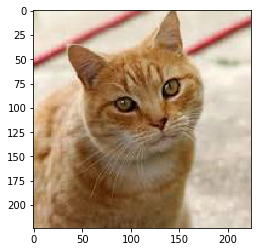

In [6]:
# getting picture of a cat
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [7]:
to_keep = np.array(np.argsort(-model.predict(x))[0][:10], dtype = np.int32)

In [8]:
def SliceLayer(to_keep):
    """ Keep only these components in the layer """
    return Lambda(lambda x : tf.gather(x, to_keep, axis = 1))

In [18]:
to_keep

array([282, 285, 281, 287, 904, 728, 588, 283, 284, 463], dtype=int32)

In [23]:
model = Model(inputs = model.input, outputs = SliceLayer(to_keep)(model.output))

In [24]:
class ModelInputCrashExperiment(Experiment):
    def __init__(self, model, p=0.01, name='exp'):
        """ Get an experiment based on a model, assuming input failures
            p failures at input
        """

        # saving p_inference
        self.p_inference = [0, p]
        
        in_shape = model.layers[0].input.shape[1:]
        out_shape = model.layers[-1].output.shape[1:]
        assert len(out_shape) == 1, "Only support 1D output"
        out_N = int(out_shape[0])

        # rewrite using https://github.com/raghakot/keras-vis/issues/37
        self.N = [0, 0, out_N]

        def IdentityLayer(input_shape=None):
            """ A layer which does nothing """
            return Lambda(
                lambda x: x + 0, input_shape=input_shape, name='Identity')

        # creating correct and crashing models
        inp = Input(shape = in_shape)
        self.model_correct  = Model(inputs = inp, outputs = model(IdentityLayer     (   input_shape = in_shape)(inp)))
        self.model_crashing = Model(inputs = inp, outputs = model(IndependentCrashes(p, input_shape = in_shape)(inp)))

In [25]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model, p = p)

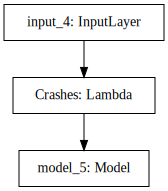

In [26]:
# plotting crashing architecture
SVG(model_to_dot(exp.model_crashing).create(prog='dot', format='svg'))

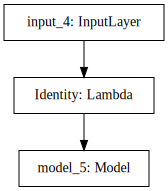

In [27]:
# plotting correct architecture
SVG(model_to_dot(exp.model_correct).create(prog='dot', format='svg'))

In [28]:
def predict(model, x):
    preds = model.predict(x)
    result = np.zeros(1000)
    preds = model.predict(x)
    for i, key in enumerate(to_keep):
        result[key] = preds[0][i]
    result = result.reshape(-1, 1000)
    print('Predicted:', decode_predictions(result, top=3)[0])

In [29]:
predict(exp.model_crashing, x)

Predicted: [('n02123159', 'tiger_cat', 0.6277061700820923), ('n02124075', 'Egyptian_cat', 0.2302580624818802), ('n02123045', 'tabby', 0.12439889460802078)]


In [30]:
predict(exp.model_correct, x)

Predicted: [('n02123159', 'tiger_cat', 0.6277058720588684), ('n02124075', 'Egyptian_cat', 0.23025795817375183), ('n02123045', 'tabby', 0.12439918518066406)]


In [32]:
r = exp.get_bound_b3(x)

In [33]:
r['mean'].shape

(10,)

In [34]:
r['mean']

array([ 5.1187050e-07, -4.8709239e-07, -3.8926064e-08,  2.0192936e-11,
        4.3099337e-09,  1.1858069e-09,  7.1231671e-10,  2.0609312e-09,
        5.1001320e-10,  3.5910866e-10], dtype=float32)

In [ ]:
np.mean(exp.compute_error(np.array(x), repetitions = 10000), axis = 1)